# Project 1

### Topic
I chose to do a more advanced dynamical model of the rocket landing. In addition to the vertical location and velocity, my model also solves for the horizontal location, velocity, and angular orientation and includes drag forces. In addition, the code has been setup with additional layers in the neural network and a batch processing system that can run, theorectically, thousands of randomized initial states at the same time.

### Dynamical Model
The dynamical model and objective model are the following. The controller features to control states, $\mathrm{\ddot{y}\left(t\right),\ddot{x}\left(t\right)}$, which are the vertical and horizontal accelerations respectively. The main engine thrust is the primary control feature for the vertical accelerations, while side thrusters are the primary controls for the horizontal accelerations and angular orientation. The state equations for the dynamic model are as follows,

$\mathrm{x\left(t+1\right)=x\left(t\right)+\dot{x}\left(t\right)\Delta t}$

$\mathrm{\dot{x}\left(t+1\right)=\dot{x}\left(t\right)+\ddot{x}\left(t\right)\Delta t}$

$\mathrm{y\left(t+1\right)=y\left(t\right)+\dot{\dot{y}\left(t\right)\Delta t}}$

$\mathrm{\dot{y}\left(t+1\right)=\dot{y}\left(t\right)+\ddot{y}\left(t\right)\Delta t}$

$\mathrm{\phi\left(t+1\right)=\phi\left(t\right)+\ddot{x}\left(t\right)\Delta t}$

Thus, the stat space of the dynamical system can be expressed as,

$\mathbf{X}\mathrm{\left(t\right)=\begin{bmatrix}x\left(t\right) & \dot{x}\left(t\right) & y\left(t\right) & \dot{y}\left(t\right) & \phi\left(t\right)\end{bmatrix}^{T}}$

The control states are expressed as,

$\mathbf{U}\mathrm{\left(t\right)=\begin{bmatrix}\ddot{y}\left(t\right) & \ddot{x}\left(t\right)\end{bmatrix}^{T}}$

The systems is controlled by a closed-loop controller defined as,

$\mathbf{U}\mathrm{\left(t\right)=\mathit{f_{\theta}}\left(\mathbf{X}\left(t\right)\right)}$

Where, $\mathit{f_{\theta}}$ is the neural network with the parameters $\mathrm{\theta}$ that are found through the optimization process.

### Optimization Model
The optimization model that was used is defined as,

$\mathrm{\underset{\theta}{min}\;\;\left\Vert \mathbf{X}\left(T\right)\right\Vert ^{2}=x\left(T\right)^{2}+\dot{x}\left(T\right)^{2}+y\left(T\right)^{2}+\dot{y}\left(T\right)^{2}+\phi\left(T\right)^{2}}$

$\mathrm{s.t.\;\;\;\;\:x\left(t+1\right)=x\left(t\right)+\dot{x}\left(t\right)\Delta t}$  
$\mathrm{\:\;\;\;\;\;\;\;\;\;\dot{x}\left(t+1\right)=\dot{x}\left(t\right)+\ddot{x}\left(t\right)\Delta t}$  
$\mathrm{\:\;\;\;\;\;\;\;\;\;y\left(t+1\right)=y\left(t\right)+\dot{\dot{y}\left(t\right)\Delta t}}$  
$\mathrm{\:\;\;\;\;\;\;\;\;\;\dot{y}\left(t+1\right)=\dot{y}\left(t\right)+\ddot{y}\left(t\right)\Delta t}$  
$\mathrm{\:\;\;\;\;\;\;\;\;\;\phi\left(t+1\right)=\phi\left(t\right)+\ddot{x}\left(t\right)\Delta t}$  
$\mathbf{U}\mathrm{\left(t\right)=\mathit{f_{\theta}}\left(\mathbf{X}\left(t\right)\right),\:\forall t=1,...,T-1}$

By defining the problem in this way, it becomes an unconstrained optimization problem w.r.t. to $\theta$. The loss/minimization function is defined above to make the perfect/ideal solution have $\mathrm{x\left(T\right)=0,\,\dot{x}\left(T\right)=0,\,y\left(T\right)=0,\,\dot{y}\left(T\right)=0,\,and\,\phi\left(T\right)=0}$. This would correspond to the rocket on the ground with zero horizontal and veritical velocity, and the angular orientation is defined such that $\mathrm{\phi\left(t\right)=0}$ corresponds to the rocket pointing in the positive vertical direction.

### Implementation

The optimization problem was solved using Pytorch and was initially based on the provided sample code. It was expanded to inlcude the extra state and control variables, adding drag, addition of randomized batch sets, updated neural network layers, and a dynamically decaying learning rate controller. 

The addition of drag proved to be the most challenging. A drag coefficient for a long cylindar was used along with the mass and dimensions of the SpaceX Falcon 9 rocket. It also takes into account the vertical position, $\mathrm{y\left(t\right)}$, to roughly vary the air density. The drag model is not very sophisticated, but for this project I feel that it does an adequate job of adding to the model.

The neural network was updated to consisit of the following sequence,  
1. Linear
2. Tanh
3. Linear
4. ELU - Exponential Linear Unit Function
5. Linear
6. ELU - with a different alpha value
7. Linear
8. SoftSign

The last layer was changed to the SoftSign function because it allows for the output variables to be negative. This helped in implementing the side thrusters so that the applied thrust could be positive or negative, essentially treating it as if there are multiple side thrusters.

Each of the state variables can be batch initailized, theoretically to thousands or even milions of sets. The initial state of each of the state variables is chosen from a random, normal distribution in the following ranges,

- $\mathrm{x:\;0.0\,to\,0.2}$
- $\mathrm{\dot{x}:\;0.0\,to\,0.2}$
- $\mathrm{y:\;0.8\,to\,1.0}$
- $\mathrm{\dot{y}:\;0.0\,to\,0.2}$
- $\mathrm{\phi:\;-0.1\,to\,0.1}$

PyTorch's ReduceLROnPlateu function was used to dynamically change the learning rate of LBFGS optimizer between loops. The criteria to change the learning rate was if 5 consectutive loops had shown an increase or no decrease in the loss function, then the leanrning rate would be reduced by a factor of 10. This did seem to prove useful as I increased the batch size and hidden parameters of the nn.

[1] loss: 103.068
[2] loss: 72.566
[3] loss: 20.887
[4] loss: 9.521
[5] loss: 7.801
[6] loss: 6.614
[7] loss: 5.786
[8] loss: 4.944
[9] loss: 4.041
[10] loss: 3.227
[11] loss: 2.550
[12] loss: 2.023
[13] loss: 1.591
[14] loss: 1.216
[15] loss: 0.887
[16] loss: 0.663
[17] loss: 0.508
[18] loss: 0.416
[19] loss: 0.359
[20] loss: 0.294
[21] loss: 0.219
[22] loss: 0.144
[23] loss: 0.092
[24] loss: 0.068
[25] loss: 0.058
[26] loss: 0.053
[27] loss: 0.051
[28] loss: 0.050
[29] loss: 0.049
[30] loss: 0.052
[31] loss: 44.344
[32] loss: 77.063
[33] loss: 32.754
[34] loss: 26.867
Epoch    35: reducing learning rate of group 0 to 1.0000e-03.
[35] loss: 18.545
[36] loss: 17.982
[37] loss: 17.267
[38] loss: 16.438
[39] loss: 15.617
[40] loss: 15.091


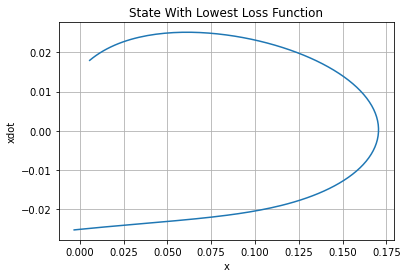

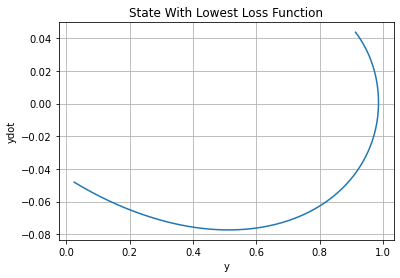

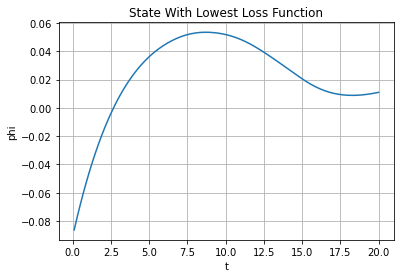

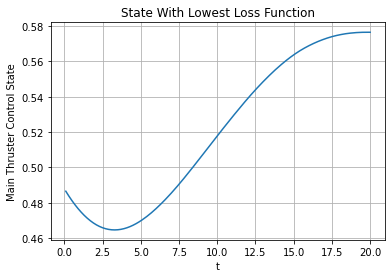

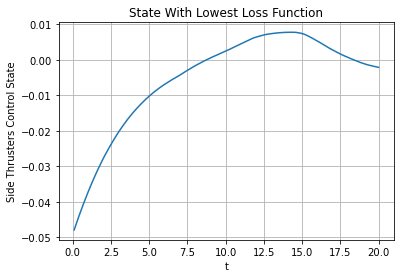

Best State:
tensor([-0.0033, -0.0254,  0.0251, -0.0481,  0.0109])
 
Action Controls:
tensor([ 0.5764, -0.0021])
 
Execution Time: 1583.07261800766 seconds


In [2]:
# MAE 598 Design Optimization - Project # 1
# Benjamin Webb
# 10/21/2022

# Import required libraries
import logging
import numpy as np
import time
import random as rnd
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define global parameters
BATCH = np.uint16(250)                     # state variables batch size
FRAME_TIME = np.single(0.1)                 # time inteval
GRAVITY_ACCEL = np.single(0.0981)             # gravitaional acceleration parameter
BOOST_ACCEL = np.single(0.18)      # Thrust accelleration parameter, main engine
BOOST2_ACCEL = np.single(0.018)     # Thrust acceleration parameter, side thrusters
RHO_0 = np.single(1.224)                    # Sea-level air density STA
A1 = np.single(42.6 * 3.66)                 # Reference area 1 for drag calculation
A2 = np.single(np.pi * 1.83**2)             # Reference area 2 for drag calculations
CD = np.single(0.82)                        # Drag coefficient of long cylinder
M = np.single(25000)                        # Mass of rocket in Kg


# Define Class for system dynamics
class Dynamics(nn.Module):

	# Initialize class
	def __init__(self):
		super(Dynamics, self).__init__()

	@staticmethod
	def forward(state, action):

		# action: thrust or no thrust
		# action[0]: thrust control, main engine
		# action[2]: omega control, side thrusters

		# State: state variables
		# state[0] = x
		# state[1] = xdot
		# state[2] = y
		# state[3] = ydot
		# state[4] = theta

		# Apply gravitational acceleration, only on ydot
		delta_gravity = torch.zeros((BATCH, 5), dtype=torch.float)
		delta_gravity = delta_gravity +\
			torch.tensor([0.0, 0.0, 0.0, -GRAVITY_ACCEL * FRAME_TIME, 0.0], dtype=torch.float)

		# Apply thrust, main engine
		tempx = torch.zeros((BATCH, 5), dtype=torch.float)
		tempy = torch.zeros((BATCH, 5), dtype=torch.float)
		tempx.index_fill_(dim=1, index=torch.tensor([1]), value=1)
		tempy.index_fill_(dim=1, index=torch.tensor([3]), value=1)
		tempx = tempx * -torch.sin(state[:, 4].detach().reshape(-1, 1))
		tempy = tempy * torch.cos(state[:, 4].detach().reshape(-1, 1))
		temp = tempx + tempy
		delta_thrust1 = BOOST_ACCEL * FRAME_TIME * torch.mul(temp, action[:, 0].reshape(-1, 1))

		# Apply thrust, side thrusters
		tempx = torch.zeros((BATCH, 5), dtype=torch.float)
		tempy = torch.zeros((BATCH, 5), dtype=torch.float)
		tempx.index_fill_(dim=1, index=torch.tensor([1]), value=1)
		tempy.index_fill_(dim=1, index=torch.tensor([3]), value=1)
		tempx = tempx * torch.cos(state[:, 4].detach().reshape(-1, 1))
		tempy = tempy * -torch.sin(state[:, 4].detach().reshape(-1, 1))
		temp = tempx + tempy
		delta_thrust2 = BOOST2_ACCEL * FRAME_TIME * torch.mul(temp, action[:, 1].reshape(-1, 1))

		# Apply drag
		rho = RHO_0 * torch.exp(-state[:, 2].detach().reshape(-1, 1))
		# Made force negative since they will cause deceleration
		Fdx = -0.5 * CD * A1 * torch.mul(rho, torch.pow(input=state[:, 1].detach().reshape(-1, 1), exponent=2))
		Fdy = -0.5 * CD * A2 * torch.mul(rho, torch.pow(input=state[:, 3].detach().reshape(-1, 1), exponent=2))
		# Acceleration due to drag
		tempx = torch.zeros((BATCH, 5), dtype=torch.float)
		tempy = torch.zeros((BATCH, 5), dtype=torch.float)
		tempx.index_fill_(dim=1, index=torch.tensor([1]), value=1)
		tempy.index_fill_(dim=1, index=torch.tensor([3]), value=1)
		adx = torch.div(torch.mul(Fdx, state[:, 1].detach().reshape(-1, 1)), M)
		ady = torch.div(torch.mul(Fdy, state[:, 3].detach().reshape(-1, 1)), M)

		tempx = torch.mul(tempx, adx)
		tempy = torch.mul(tempy, ady)
		temp_state = tempx + tempy

		delta_drag = torch.mul(temp_state, FRAME_TIME)

		# Apply change in theta
		delta_theta = FRAME_TIME * torch.mul(torch.tensor([0.0, 0.0, 0.0, 0.0, -1.0]), action[:, 1].reshape(-1, 1))

		# Combine dynamics
		state = state + delta_gravity + delta_thrust1 + delta_thrust2 + delta_drag + delta_theta

		# Update state vector
		step_mat = torch.tensor([[1.0, FRAME_TIME, 0.0, 0.0, 0.0],
		                         [0.0, 1.0, 0.0, 0.0, 0.0],
		                         [0.0, 0.0, 1.0, FRAME_TIME, 0.0],
		                         [0.0, 0.0, 0.0, 1.0, 0.0],
		                         [0.0, 0.0, 0.0, 0.0, 1.0]], dtype=torch.float)

		state = torch.matmul(step_mat, state.T)

		return state.T

# Define Controller Class
class Controller(nn.Module):

	# Initialize class
	def __init__(self, dim_input, dim_hidden, dim_output):
		# dim_input: # of system states
		# dim_output: # of actions
		# dim_hidden: TBD

		super(Controller, self).__init__()
		# Added 2 extra layers
		self.network = nn.Sequential(nn.Linear(dim_input, dim_hidden),
		                             nn.Tanh(), nn.Linear(dim_hidden, dim_hidden),
		                             nn.ELU(),  nn.Linear(dim_hidden, dim_hidden),
		                             nn.ELU(alpha=0.5), nn.Linear(dim_hidden, dim_output), nn.Softsign())

	# define Controller forward method
	def forward(self, state):
		action = self.network(state)
		return action

# Define Simulation Class
class Simulation(nn.Module):

	# Initialize Class
	def __init__(self, controller, dynamics, T):
		super(Simulation, self).__init__()
		self.state = self.intialize_state()
		self.controller = controller
		self.dynamics = dynamics
		self.T = T
		self.action_trajectory = []
		self.state_trajectory = []

	# Define Simulation class forward method
	def forward(self, state):
		self.action_trajectory = []
		self.state_trajectory = []
		for _ in range(self.T):
			action = self.controller.forward(state)
			state = self.dynamics.forward(state, action)
			self.action_trajectory.append(action)
			self.state_trajectory.append(state)

		return self.error(state)

	@staticmethod
	def intialize_state():
		# Batch
		rand = np.zeros((BATCH, 5), dtype=np.single)
		for i in range(BATCH):
			rand[i, 0] = rnd.uniform(0.0, 0.2)
			rand[i, 1] = rnd.uniform(0.0, 0.2)
			rand[i, 2] = rnd.uniform(0.8, 1.0)
			rand[i, 3] = rnd.uniform(0.0, 0.2)
			rand[i, 4] = rnd.uniform(-0.1, 0.1)

		state = torch.tensor(data=rand, dtype=torch.float, requires_grad=False)

		return state

	# Define Simulation class error
	@staticmethod
	def error(state):
		# Sum of squares all divided by number of batches
		return torch.sum(torch.pow(input=state, exponent=2)) / np.single(BATCH)

# Define Optimizer class. Currently, using LBFGS
class Optimize:

	# Initialize class
	def __init__(self, simulation):
		super(Optimize, self).__init__()
		self.simulation = simulation
		self.parameters = simulation.controller.parameters()
		self.optimizer = optim.LBFGS(self.parameters, lr=0.01)
		# Implementing dynamic learning rate
		self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=self.optimizer, patience=5, verbose=True)
		# Parameter for plotting
		self.best_loss = torch.tensor(np.inf, dtype=torch.float, requires_grad=False)
		self.best_state = torch.zeros((self.simulation.T, 5), dtype=torch.float, requires_grad=False)
		self.best_action = torch.zeros((self.simulation.T, 2), dtype=torch.float, requires_grad=False)

	# Define Optmize class step function
	def step(self):
		# Define Closure function so gradient can be calculated multiple times
		def closure():
			loss = self.simulation(self.simulation.state)
			self.optimizer.zero_grad()
			loss.backward()

			return loss

		# Possible reccursive operation
		self.optimizer.step(closure)

		return closure()

	# Define Optimize class train function
	def train(self, epochs):
		for epoch in range(epochs):
			loss = self.step()
			self.scheduler.step(metrics=loss)
			print('[%d] loss: %.3f' % (epoch + 1, loss))
			if loss < self.best_loss:
				self.best_loss = loss
				temp = self.simulation.state_trajectory[-1].detach()
				(minx, idx) = torch.min(torch.linalg.vector_norm(temp, ord=2, dim=1).reshape(-1, 1), dim=0)
				for i in range(self.simulation.T):
					temp_state = self.simulation.state_trajectory[i].detach()
					temp_action = self.simulation.action_trajectory[i].detach()
					self.best_state[i, :] = temp_state[idx, :]
					self.best_action[i, :] = temp_action[idx, :]

			if epoch == epochs - 1:
				self.visualize()

	# Define Optimize class visulize function
	def visualize(self):
		data = np.array(self.best_state.detach())
		data2 = np.array(self.best_action.detach())
		t = np.arange(0.1, 20.1, 0.1)

		x1 = data[:, 0]
		y1 = data[:, 1]
		plt.figure(num=1)
		plt.plot(x1, y1)
		plt.grid(visible=True, which='both', axis='both')
		plt.title('State With Lowest Loss Function')
		plt.ylabel('xdot')
		plt.xlabel('x')
		plt.show()

		x1 = data[:, 2]
		y1 = data[:, 3]
		plt.figure(num=2)
		plt.plot(x1, y1)
		plt.grid(visible=True, which='both', axis='both')
		plt.title('State With Lowest Loss Function')
		plt.ylabel('ydot')
		plt.xlabel('y')
		plt.show()

		x1 = t
		y1 = data[:, 4]
		plt.figure(num=3)
		plt.plot(x1, y1)
		plt.grid(visible=True, which='both', axis='both')
		plt.title('State With Lowest Loss Function')
		plt.ylabel('phi')
		plt.xlabel('t')
		plt.show()

		x1 = t
		y1 = data2[:, 0]
		plt.figure(num=4)
		plt.plot(x1, y1)
		plt.grid(visible=True, which='both', axis='both')
		plt.title('State With Lowest Loss Function')
		plt.ylabel('Main Thruster Control State')
		plt.xlabel('t')
		plt.show()

		x1 = t
		y1 = data2[:, 1]
		plt.figure(num=5)
		plt.plot(x1, y1)
		plt.grid(visible=True, which='both', axis='both')
		plt.title('State With Lowest Loss Function')
		plt.ylabel('Side Thrusters Control State')
		plt.xlabel('t')
		plt.show()


# Define main program script
if __name__ == '__main__':

	# Begin timer
	start_time = time.time()

	# Initial test to ensure code is working
	T = 200             # number of time steps
	dim_input = 5       # number of state-space variables, currently 5
	dim_hidden = 500    # size of neurnal network
	dim_output = 2      # number of actions, currently 2

	d = Dynamics()                                      # Created Dynamics class object
	c = Controller(dim_input, dim_hidden, dim_output)   # Created Controller class object
	s = Simulation(controller=c, dynamics=d, T=T)       # Created Simulation class object
	o = Optimize(simulation=s)                          # Created Optimizer Class object
	o.train(epochs=40)                                  # Test code

	# End timer
	end_time = time.time()

	# Print Final state trajectory and action trajectory
	print('Best State:')
	print(o.best_state[T-1, :])
	print(' ')
	print('Action Controls:')
	print(o.best_action[T-1, :])
	print(' ')

	# Print program execution time
	total_time = end_time - start_time
	print('Execution Time:', total_time, 'seconds')


### Results

Several different time steps, neural network parameters, and batch sizes were tested. Initially, a larger time step of up to 1 was found to be better for convergence. This however was the case before I changed the different layers in the neural network. With the change, it seemed to help with convergence and better results were found by decreasing the time step back to 0.1.

What appears to be the biggest factor for convergence, and isn't that surprising, is the number of neural network parameters and the batch size. Increasing both provided significant improvements in the convergence. Unfortunatly, this comes at the price of computational time. If I had more time, and a bit more knowledge with Pytorch, I would have liked to have implemented a nested optimization loop. The secondary optimization would have been on the neural network and optimizer perameters.

I did notice that often the solution would converge and then the optimizer would go off in the wrong direction. I am unsure if that is due to non-optimized neural network parameters or if the dynamically decaying learning rate settings are not optimized. Regardless, a converged solution was generally found just at the expense of wasted optimization loops near the end.

In addition to implementing a nested optimizer for the parameters, I would have liked to have implemented some type of parallelization to helps speed up the code. Perhaps also implement an option to run it on a gpu if one is available to you. If the code could be speed up, then additinal hidden nn parameters and an increased batch size could be used. I definetly believe, that this could help find an even more optimal solution.

As we can see from the solution above, we get very close to a zero loss state after the 29th loop. However, the optimizer then begins to move away from that state, something that I noticed to happen often. Furthermore, as in the solution above, the optimizer would generally start to converge again. This is another reason why I believe if I had the resources to run more nn parameters, larger batch sizes, and more optimization loops, I would find a very close to zero (if not zero) loss state.

As we can see from this solution, we don't quite reach an optimal zero loss state. The final values of all of the states, particularly x, y, and phi, are close to zero. However, in a real-world situation they would not be nearly good enough. The x and y velocities are still a bit high. I again believe that I could achieve a better solution given more time and better computational resources.